# 🤖 Facial Emotion Recognition Training - Google Colab

This notebook trains an EfficientNet-B0 model for facial emotion recognition with 5 classes:
- Angry
- Happy
- Neutral
- Sad
- Surprised

**Features:**
- Load dataset from uploaded ZIP file
- Early stopping to prevent overfitting
- Learning rate scheduling
- Data augmentation
- Progress bars and visualization
- Automatic checkpointing
- Save models to Google Drive

## 1. Upload and Extract Dataset ZIP File

Upload your dataset as a ZIP file with this structure:
```
emotion_dataset.zip
├── train/
│   ├── angry/
│   ├── happy/
│   ├── neutral/
│   ├── sad/
│   └── surprised/
├── val/
│   └── (same structure)
└── test/
    └── (same structure)
```

In [1]:
from google.colab import files
import zipfile
import os
import shutil

print("📦 Please upload your emotion dataset ZIP file...")
print("   (This may take a few minutes depending on file size)\n")

# Upload the zip file
uploaded = files.upload()

# Get the uploaded file name
zip_filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {zip_filename}")

# Extract the zip file
print(f"📂 Extracting {zip_filename}...")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/emotion_data')

print("✓ Extraction complete!")

# Find the data directory (handle different zip structures)
# Check if extracted directly or in a subfolder
if os.path.exists('/content/emotion_data/train'):
    DATA_DIR = '/content/emotion_data'
else:
    # Look for the actual data folder
    subdirs = [d for d in os.listdir('/content/emotion_data') if os.path.isdir(os.path.join('/content/emotion_data', d))]
    if subdirs:
        DATA_DIR = os.path.join('/content/emotion_data', subdirs[0])
    else:
        DATA_DIR = '/content/emotion_data'

print(f"\n📁 Dataset location: {DATA_DIR}")

# Verify the structure
print("\n🔍 Verifying dataset structure...")
for split in ['train', 'val', 'test']:
    split_path = os.path.join(DATA_DIR, split)
    if os.path.exists(split_path):
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        num_images = sum([len(os.listdir(os.path.join(split_path, c))) for c in classes])
        print(f"  ✓ {split:5s}: {len(classes)} classes, {num_images:,} images")
    else:
        print(f"  ✗ {split:5s}: NOT FOUND")

# Clean up the zip file to save space
os.remove(zip_filename)
print(f"\n🗑️  Removed zip file to save space")

📦 Please upload your emotion dataset ZIP file...
   (This may take a few minutes depending on file size)



Saving emotion_dataset.zip to emotion_dataset.zip

✓ File uploaded: emotion_dataset.zip
📂 Extracting emotion_dataset.zip...
✓ Extraction complete!

📁 Dataset location: /content/emotion_data/emotion_data

🔍 Verifying dataset structure...
  ✓ train: 5 classes, 40,267 images
  ✗ val  : NOT FOUND
  ✓ test : 5 classes, 5,000 images

🗑️  Removed zip file to save space


## 2. Mount Google Drive (for saving models)

Models will be saved to Google Drive so you don't lose them.

In [2]:
from google.colab import drive

# Mount Google Drive for saving models
drive.mount('/content/drive')

# Create model directory
MODEL_SAVE_DIR = '/content/drive/MyDrive/robot_final'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"💾 Models will be saved to: {MODEL_SAVE_DIR}")

Mounted at /content/drive
✓ Google Drive mounted
💾 Models will be saved to: /content/drive/MyDrive/robot_final


## 3. Import Libraries and Check GPU

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.74 GB


## 4. Configuration and Hyperparameters

In [4]:
# Training configuration
BATCH_SIZE = 64
EPOCHS = 50  # Maximum epochs (early stopping will halt if needed)
LEARNING_RATE = 0.0001
NUM_CLASSES = 5
IMG_SIZE = 224

# Early stopping configuration
EARLY_STOP_PATIENCE = 3  # Stop if no improvement for 7 epochs
EARLY_STOP_MIN_DELTA = 0.005  # Minimum improvement (0.1%) to count as progress

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model save path with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, f'best_b0.pth')
FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, f'final_b0.pth')

print(f"\nTraining Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Early stop patience: {EARLY_STOP_PATIENCE}")
print(f"  Min delta: {EARLY_STOP_MIN_DELTA}")
print(f"\nModel will be saved to Google Drive:")
print(f"  Best: {BEST_MODEL_PATH}")
print(f"  Final: {FINAL_MODEL_PATH}")

Using device: cuda

Training Configuration:
  Batch size: 64
  Max epochs: 50
  Learning rate: 0.0001
  Early stop patience: 3
  Min delta: 0.005

Model will be saved to Google Drive:
  Best: /content/drive/MyDrive/robot_final/best_b0.pth
  Final: /content/drive/MyDrive/robot_final/final_b0.pth


## 5. Data Transforms and Augmentation

In [5]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# No augmentation for validation/test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Transforms defined")

✓ Transforms defined


## 6. Load Datasets from Extracted Files

In [6]:
# Load datasets from extracted files
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ Datasets loaded")
print(f"Train samples: {len(train_dataset):,}")
print(f"Valid samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Classes: {train_dataset.classes}")

✓ Datasets loaded
Train samples: 40,267
Valid samples: 5,035
Test samples: 5,000
Classes: ['angry', 'happy', 'neutral', 'sad', 'surprised']


## 7. Create Model (EfficientNet-B0)

In [7]:
# Load pre-trained EfficientNet-B0 and modify for 5 classes
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout for regularization
    nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
)
model = model.to(device)

print("✓ Model loaded and modified for 5 classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 216MB/s]


✓ Model loaded and modified for 5 classes
Total parameters: 4,013,953
Trainable parameters: 4,013,953


## 8. Training Setup (Loss, Optimizer, Scheduler)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

print("✓ Criterion, optimizer, and scheduler ready")

✓ Criterion, optimizer, and scheduler ready


## 9. Early Stopping Class

In [9]:
class EarlyStopping:
    """
    Early stopping to stop training when validation accuracy stops improving.
    """
    def __init__(self, patience=3, min_delta=0.005, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_acc, epoch):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            if self.verbose:
                print(f"  📊 Baseline validation accuracy: {val_acc:.2f}%")
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"  ⚠️ No improvement for {self.counter}/{self.patience} epochs")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n🛑 Early stopping triggered!")
                    print(f"  Best validation accuracy: {self.best_score:.2f}% at epoch {self.best_epoch + 1}")
        else:
            improvement = score - self.best_score
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f"  📈 Improvement: +{improvement:.2f}% (counter reset)")

print("✓ Early stopping class defined")

✓ Early stopping class defined


## 10. Training and Validation Functions

In [10]:
def train_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]',
                leave=False, ncols=100)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        current_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{current_acc:.2f}%'})

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, accuracy

def validate(model, loader, criterion, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]',
                leave=False, ncols=100)

    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            current_acc = 100. * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}',
                             'acc': f'{current_acc:.2f}%'})

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, accuracy

print("✓ Training functions defined")

✓ Training functions defined


## 11. Training Loop with Early Stopping

In [11]:
# Initialize tracking variables
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
early_stopping = EarlyStopping(patience=EARLY_STOP_PATIENCE,
                                min_delta=EARLY_STOP_MIN_DELTA,
                                verbose=True)

start_time = time.time()

print("🚀 Starting training...\n")
print("="*70)

for epoch in range(EPOCHS):
    # Train with progress bar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)

    # Validate with progress bar
    val_loss, val_acc = validate(model, val_loader, criterion, epoch)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train → Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   → Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # Save best model to Google Drive
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, BEST_MODEL_PATH)
        print(f"  ✅ Best model saved to Google Drive! (Val Acc: {val_acc:.2f}%)")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Early stopping check
    early_stopping(val_acc, epoch)
    if early_stopping.early_stop:
        print(f"\n🛑 Training stopped early at epoch {epoch + 1}")
        break

    print("-"*70)

# Save final model to Google Drive
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'val_loss': val_loss,
    'history': history
}, FINAL_MODEL_PATH)

training_time = time.time() - start_time

print("\n" + "="*70)
print("✅ Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Training time: {training_time/60:.2f} minutes")
print(f"  Total epochs: {epoch + 1}")
print(f"\n💾 Models saved to Google Drive:")
print(f"  Best: {BEST_MODEL_PATH}")
print(f"  Final: {FINAL_MODEL_PATH}")
print("="*70)

🚀 Starting training...




📊 Epoch 1/50
  Train → Loss: 1.0767, Acc: 55.96%
  Val   → Loss: 0.8285, Acc: 67.65%
  ✅ Best model saved to Google Drive! (Val Acc: 67.65%)
  📊 Baseline validation accuracy: 67.65%
----------------------------------------------------------------------



📊 Epoch 2/50
  Train → Loss: 0.7855, Acc: 69.70%
  Val   → Loss: 0.7489, Acc: 71.58%
  ✅ Best model saved to Google Drive! (Val Acc: 71.58%)
  📈 Improvement: +3.93% (counter reset)
----------------------------------------------------------------------



📊 Epoch 3/50
  Train → Loss: 0.6920, Acc: 73.58%
  Val   → Loss: 0.7172, Acc: 73.58%
  ✅ Best model saved to Google Drive! (Val Acc: 73.58%)
  📈 Improvement: +2.01% (counter reset)
----------------------------------------------------------------------



📊 Epoch 4/50
  Train → Loss: 0.6241, Acc: 76.06%
  Val   → Loss: 0.7452, Acc: 73.58%
  ⚠️ No improvement for 1/3 epochs
----------------------------------------------------------------------



📊 Epoch 5/50
  Train → Loss: 0.5661, Acc: 78.75%
  Val   → Loss: 0.7107, Acc: 74.98%
  ✅ Best model saved to Google Drive! (Val Acc: 74.98%)
  📈 Improvement: +1.39% (counter reset)
----------------------------------------------------------------------



📊 Epoch 6/50
  Train → Loss: 0.5101, Acc: 80.62%
  Val   → Loss: 0.7455, Acc: 74.66%
  ⚠️ No improvement for 1/3 epochs
----------------------------------------------------------------------



📊 Epoch 7/50
  Train → Loss: 0.4605, Acc: 82.75%
  Val   → Loss: 0.7757, Acc: 74.82%
  ⚠️ No improvement for 2/3 epochs
----------------------------------------------------------------------



📊 Epoch 8/50
  Train → Loss: 0.4167, Acc: 84.52%
  Val   → Loss: 0.7940, Acc: 73.98%
  ⚠️ No improvement for 3/3 epochs

🛑 Early stopping triggered!
  Best validation accuracy: 74.98% at epoch 5

🛑 Training stopped early at epoch 8

✅ Training complete!
  Best validation accuracy: 74.98%
  Training time: 30.13 minutes
  Total epochs: 8

💾 Models saved to Google Drive:
  Best: /content/drive/MyDrive/robot_final/best_b0.pth
  Final: /content/drive/MyDrive/robot_final/final_b0.pth


## 12. Plot Training History

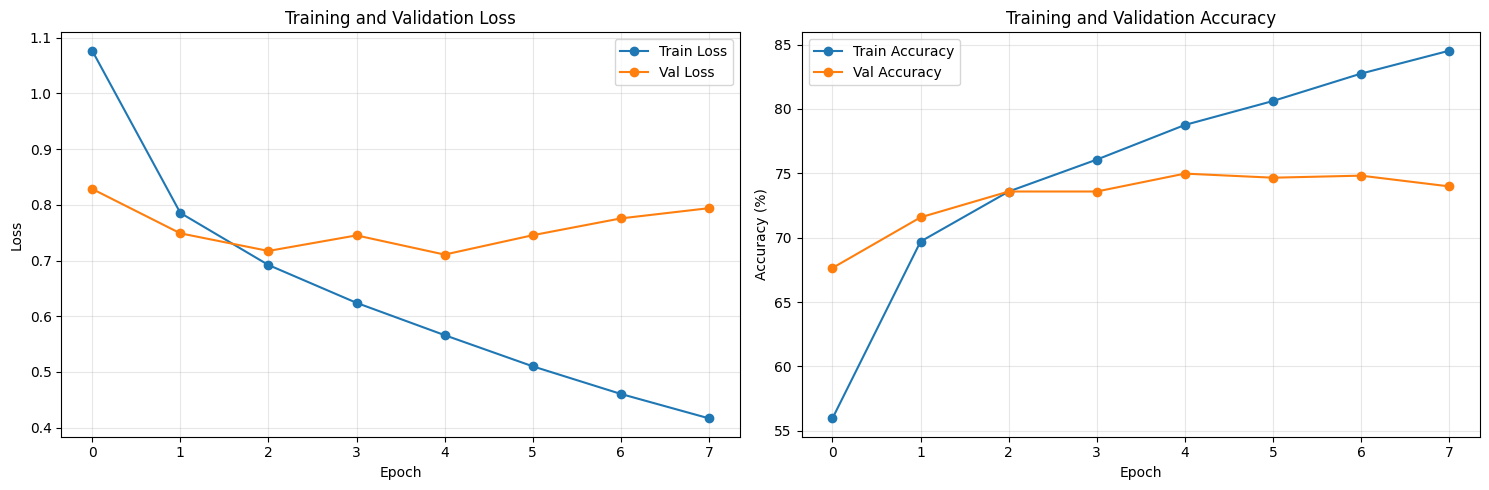


📈 Training plot saved to Google Drive


In [12]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, f'training_history_{timestamp}.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 Training plot saved to Google Drive")

## 13. Evaluate on Test Set

In [13]:
# Load best model for testing
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

print("\nEvaluating on test set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate test accuracy
test_acc = 100.0 * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")

✓ Loaded best model (Val Acc: 74.98%)

Evaluating on test set...


Testing: 100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


✅ Test Accuracy: 75.08%


## 14. Confusion Matrix and Classification Report

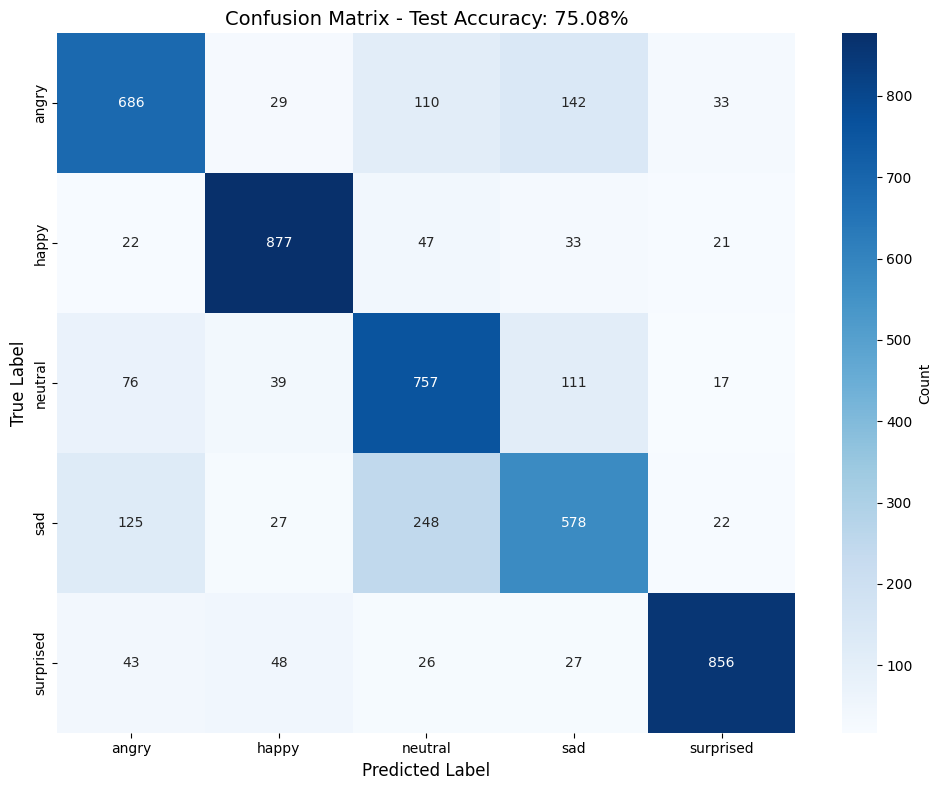


📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.72      0.69      0.70      1000
       happy       0.86      0.88      0.87      1000
     neutral       0.64      0.76      0.69      1000
         sad       0.65      0.58      0.61      1000
   surprised       0.90      0.86      0.88      1000

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000


📈 Per-Class Accuracy:
     angry: 68.60% (686/1000)
     happy: 87.70% (877/1000)
   neutral: 75.70% (757/1000)
       sad: 57.80% (578/1000)
 surprised: 85.60% (856/1000)

💾 Confusion matrix saved to Google Drive


In [14]:
# Get class names
class_names = train_dataset.classes

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, f'confusion_matrix_{timestamp}.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print classification report
print("\n📊 Classification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Calculate per-class accuracy
print("\n📈 Per-Class Accuracy:")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = 100.0 * class_correct / class_total
    print(f"{class_name:>10s}: {class_acc:.2f}% ({class_correct}/{class_total})")

print(f"\n💾 Confusion matrix saved to Google Drive")

## 15. Export Model to ONNX (Optional)

This allows you to use the model with other frameworks and on edge devices.

In [15]:
# Export to ONNX format
try:
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    onnx_path = os.path.join(MODEL_SAVE_DIR, f'emotion_model_{timestamp}.onnx')

    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )

    print(f"✅ Model exported to ONNX format")
    print(f"   Path: {onnx_path}")
    print(f"\n💡 You can now use this model with ONNX Runtime on Raspberry Pi!")
except Exception as e:
    print(f"⚠️ ONNX export failed: {e}")
    print("   This is optional and doesn't affect your trained model.")

⚠️ ONNX export failed: No module named 'onnxscript'
   This is optional and doesn't affect your trained model.


## 16. Training Summary

In [16]:
print("\n" + "="*70)
print("📋 TRAINING SUMMARY")
print("="*70)
print(f"\n🎯 Model Performance:")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Final Test Accuracy: {test_acc:.2f}%")

print(f"\n⏱️ Training Details:")
print(f"   Total Epochs: {epoch + 1}/{EPOCHS}")
print(f"   Training Time: {training_time/60:.2f} minutes")
print(f"   Early Stopping: {'Yes' if early_stopping.early_stop else 'No'}")
if early_stopping.early_stop:
    print(f"   Stopped at Epoch: {epoch + 1}")
    print(f"   Patience Used: {EARLY_STOP_PATIENCE} epochs")

print(f"\n📁 Saved Files in Google Drive:")
print(f"   {MODEL_SAVE_DIR}/")
print(f"   ├── best_emotion_model_{timestamp}.pth")
print(f"   ├── final_emotion_model_{timestamp}.pth")
print(f"   ├── training_history_{timestamp}.png")
print(f"   ├── confusion_matrix_{timestamp}.png")
if os.path.exists(os.path.join(MODEL_SAVE_DIR, f'emotion_model_{timestamp}.onnx')):
    print(f"   └── emotion_model_{timestamp}.onnx")

print(f"\n💡 Next Steps:")
print(f"   1. Download the .pth or .onnx model from Google Drive")
print(f"   2. Use it with your Raspberry Pi robot")
print(f"   3. Check the training plots to understand model behavior")
print("\n" + "="*70)


📋 TRAINING SUMMARY

🎯 Model Performance:
   Best Validation Accuracy: 74.98%
   Final Test Accuracy: 75.08%

⏱️ Training Details:
   Total Epochs: 8/50
   Training Time: 30.13 minutes
   Early Stopping: Yes
   Stopped at Epoch: 8
   Patience Used: 3 epochs

📁 Saved Files in Google Drive:
   /content/drive/MyDrive/robot_final/
   ├── best_emotion_model_20251208_134952.pth
   ├── final_emotion_model_20251208_134952.pth
   ├── training_history_20251208_134952.png
   ├── confusion_matrix_20251208_134952.png

💡 Next Steps:
   1. Download the .pth or .onnx model from Google Drive
   2. Use it with your Raspberry Pi robot
   3. Check the training plots to understand model behavior

